In [71]:
import os
from sys import platform
import pandas as pd
import numpy as np
# import plotly.express as px
# from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


# Wine data
4. Relevant Information:

   The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
   For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
   Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables 
   are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

   These datasets can be viewed as classification or regression tasks.
   The classes are ordered and not balanced (e.g. there are munch more normal wines than
   excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent
   or poor wines. Also, we are not sure if all input variables are relevant. So
   it could be interesting to test feature selection methods. 

5. Number of Instances: red wine - 1599; white wine - 4898. 

6. Number of Attributes: 11 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

7. Attribute information:

   For more information, read [Cortez et al., 2009].

   Input variables (based on physicochemical tests):
   1 - fixed acidity
   2 - volatile acidity
   3 - citric acid
   4 - residual sugar
   5 - chlorides
   6 - free sulfur dioxide
   7 - total sulfur dioxide
   8 - density
   9 - pH
   10 - sulphates
   11 - alcohol
   Output variable (based on sensory data): 
   12 - quality (score between 0 and 10)

8. Missing Attribute Values: None


# Normalization techniques

## TanH
$x'_{i,n} = \frac{1}{2}\left[\tanh[{0.01(\frac{x_{i,n-\mu^{H}_i}}{\sigma^H_i})}] +1\right]$

In [74]:
def z_score(data):
    scaler = StandardScaler()
    data_without_cat = data.select_dtypes(exclude='category')
    data[data_without_cat.columns] = scaler.fit_transform(data_without_cat)
    return data
        
def tanh_norm(df):
    #Reduce influence of the values in the tail of the distribution

        m = np.mean(df.iloc[:,:-1], axis=0) # array([16.25, 26.25])
        std = np.std(df.iloc[:,:-1], axis=0) # array([17.45530005, 22.18529919])

        tanh_df = 0.5 * (np.tanh(0.01 * ((df.iloc[:,:-1] - m) / std)) + 1)
        return tanh_df

def min_max(data):
    scaler = MinMaxScaler()
    data.iloc[:,:-1] = scaler.fit_transform(data.iloc[:,:-1])
    return data
def pareto_scaling(df):
    pass
def variable_stability_scaling():
    pass
def load_data(dataset:str):
    cwd = os.getcwd()
    separator = '\\' if platform == 'win32' else '/'
    if dataset == "wine":
        w = pd.read_csv(r"C:\Users\johan\Documents\GitHub\kth_private\project_course\datasets\wine\winequality-white.csv",delimiter=";")
        r  = pd.read_csv(r"C:\Users\johan\Documents\GitHub\kth_private\project_course\datasets\wine\winequality-red.csv",delimiter=";")
        r['color'] = 'red'
        w['color'] = 'white'
        df = r.append(w)
        df = df.sample(frac=1).reset_index(drop=True)
    elif dataset == "adult":
        column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship',
                        'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
        dtypes = {'age': np.int64, 'workclass': 'category', 'fnlwgt': np.int64, 'education': 'category', 'education_num': np.int64, 
                  'marital_status': 'category', 'occupation': 'category', 'relationship': 'category', 'race': 'category', 'sex': 'category', 
                  'capital_gain': np.int64, 'capital_loss': np.int64, 'hours_per_week': np.int64, 'native_country': 'category', 'income': 'category'}
        df = pd.read_csv(cwd + separator + 'datasets' + separator + 'adult' + separator + 'adult.data', delimiter=', ', names=column_names, dtype=dtypes, index_col=False)
    else:
        raise NameError("Not implemented yet")
    return df
class Normalizator():
    def __init__(self,dataset:str):
        """
        Class that reads data and performs normalization methods
        Args:
            - dataset : str of the type of dataset to use, not that this also needs to be implemented as a separete field in load_data
        Methods:
            - normalize: function to normalize the data given method
            - boxplot: creates subplots of all variables
            
        """
        
        self.dataset = dataset
        self.df = load_data(self.dataset)
        self.df_norm = None
        
        self.df = self.df.apply(self.encode_var,axis=0)
    
    #function to encode pandas variable types to int, float, or category
    def encode_var(self,var):
        if var.dtype == 'object':
            var = var.astype('category')
        elif var.dtype == 'category':
            var = var.cat.codes
        elif var.dtype == 'int64':
            var = var.astype('float64')
        return var
    def normalize(self,method="zscore",reset=False):
        # just to make sure the data is not tampered with before normalization
        if reset:
            self.df = load_data(self.dataset) 
        if method == "zscore": 
            self.df_norm = z_score(self.df)
        elif method == "tanh":
            self.df_norm = tanh_norm(self.df) 
        elif method == "zscore":
            self.df_norm = z_score(self.df)
        elif method == "zscore":
            self.df_norm = z_score(self.df)
    def visuals(self):
        fig, axes = plt.subplots(3,4,figsize=(15,15))
        for i,el in enumerate(list(self.df.columns.values)[:-1]):
                a = self.df.boxplot(el, ax=axes.flatten()[i])

        
        b = self.df.hist(figsize=(15,15))
        plt.tight_layout() 

        plt.show()

    def lblEncoder(self,col):
        le = LabelEncoder()
        le.fit(self.df[col])
        self.df[col] = le.transform(self.df[col])
        return self.df

    def run_model(self,model=None):
        if not model:
            raise TypeError("Need to specify model type")
        elif model =="knn":
            categorical = self.df_norm.select_dtypes('category')
            self.df_norm[categorical.columns] = categorical.apply(LabelEncoder().fit_transform)
            X = self.df_norm.iloc[:,:-1]
            y = self.df_norm.iloc[:,-1]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            knn = KNeighborsClassifier(n_neighbors=3)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            print(confusion_matrix(y_test, y_pred))
            print(classification_report(y_test, y_pred))



    

In [48]:
obj = Normalizator(dataset="adult")
obj.df.describe()

<ipython-input-28-e8e0f00f4b0f>:35: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(cwd + separator + 'datasets' + separator + 'adult' + separator + 'adult.data', delimiter=', ', names=column_names, dtype=dtypes, index_col=False)


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


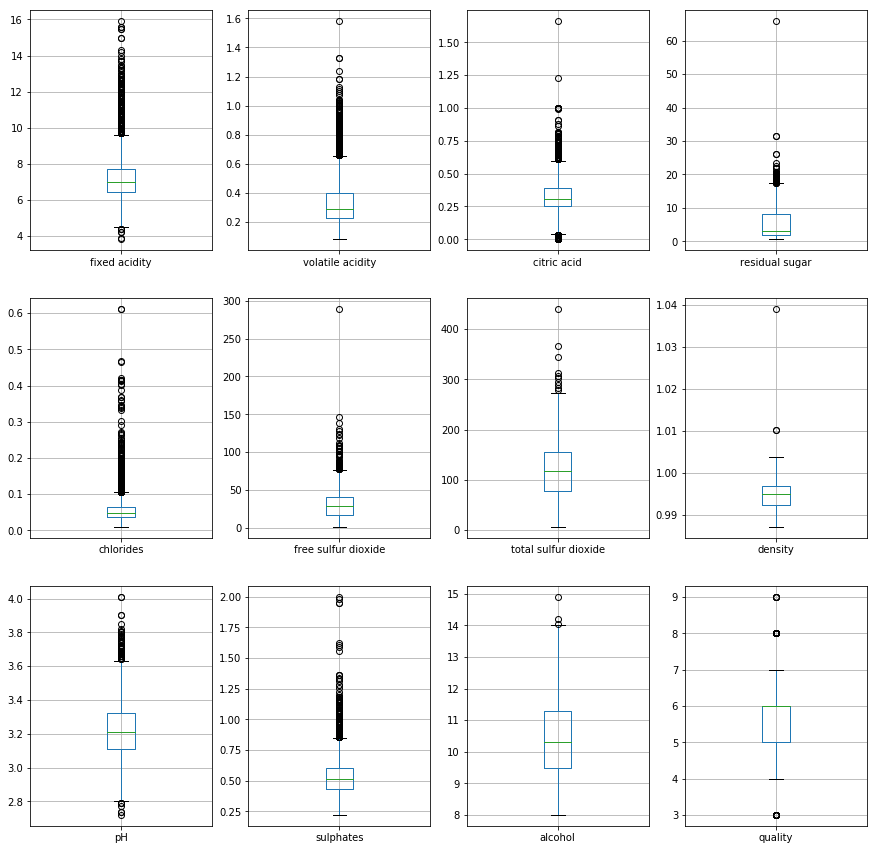

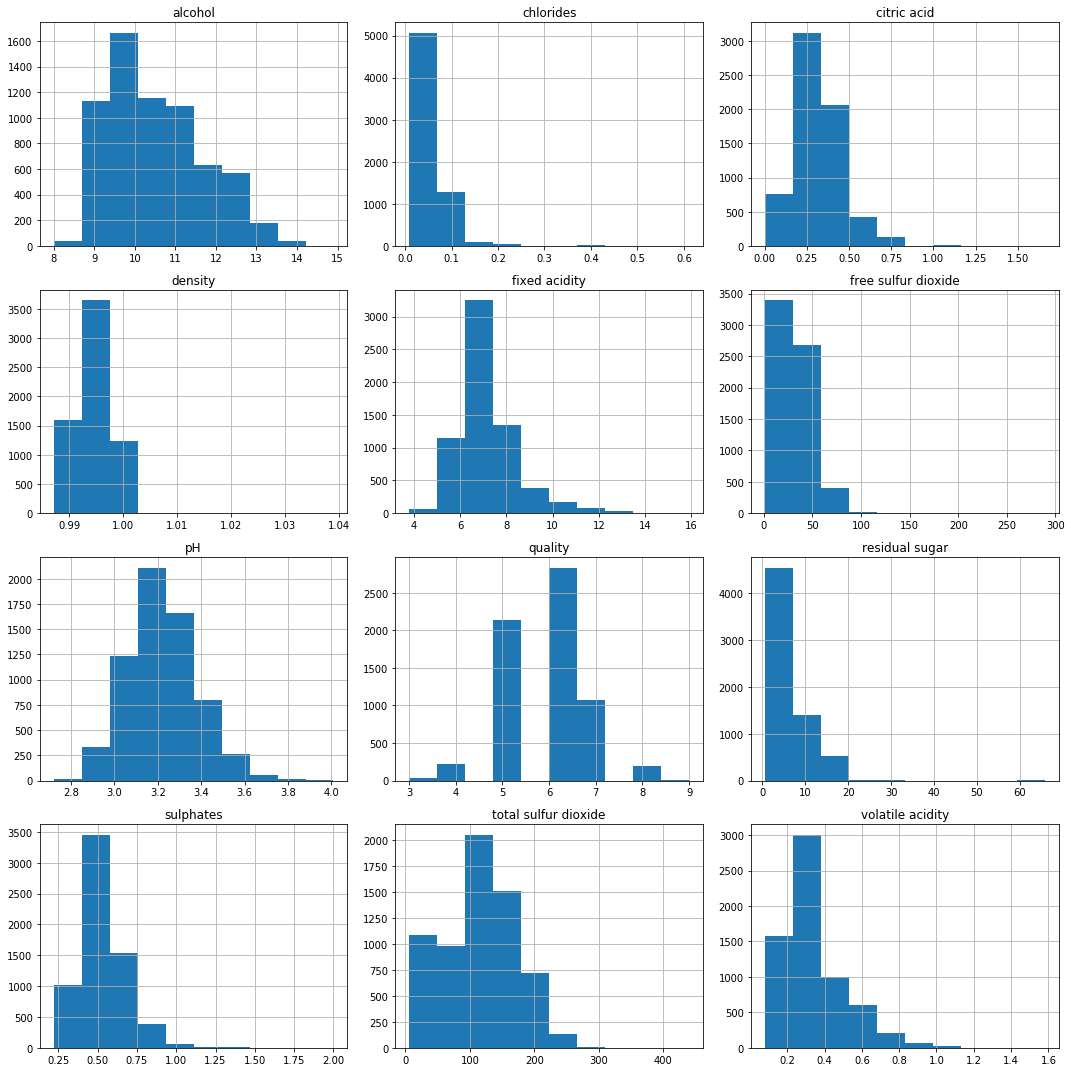

In [49]:
obj.visuals()

C:\Users\johan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

C:\Users\johan\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



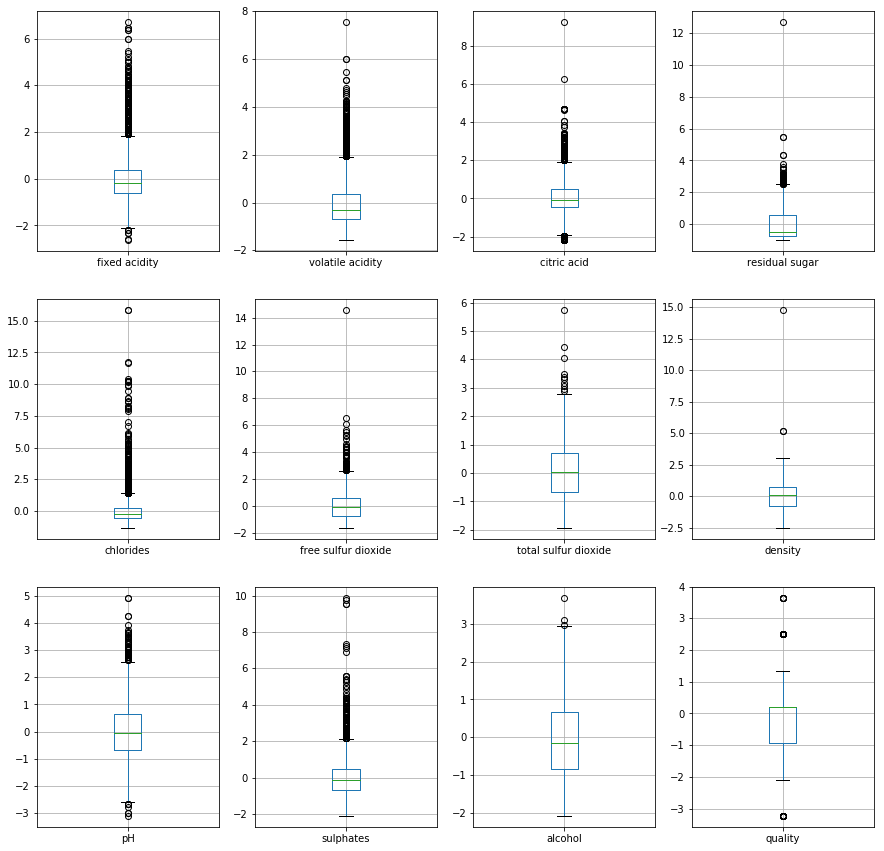

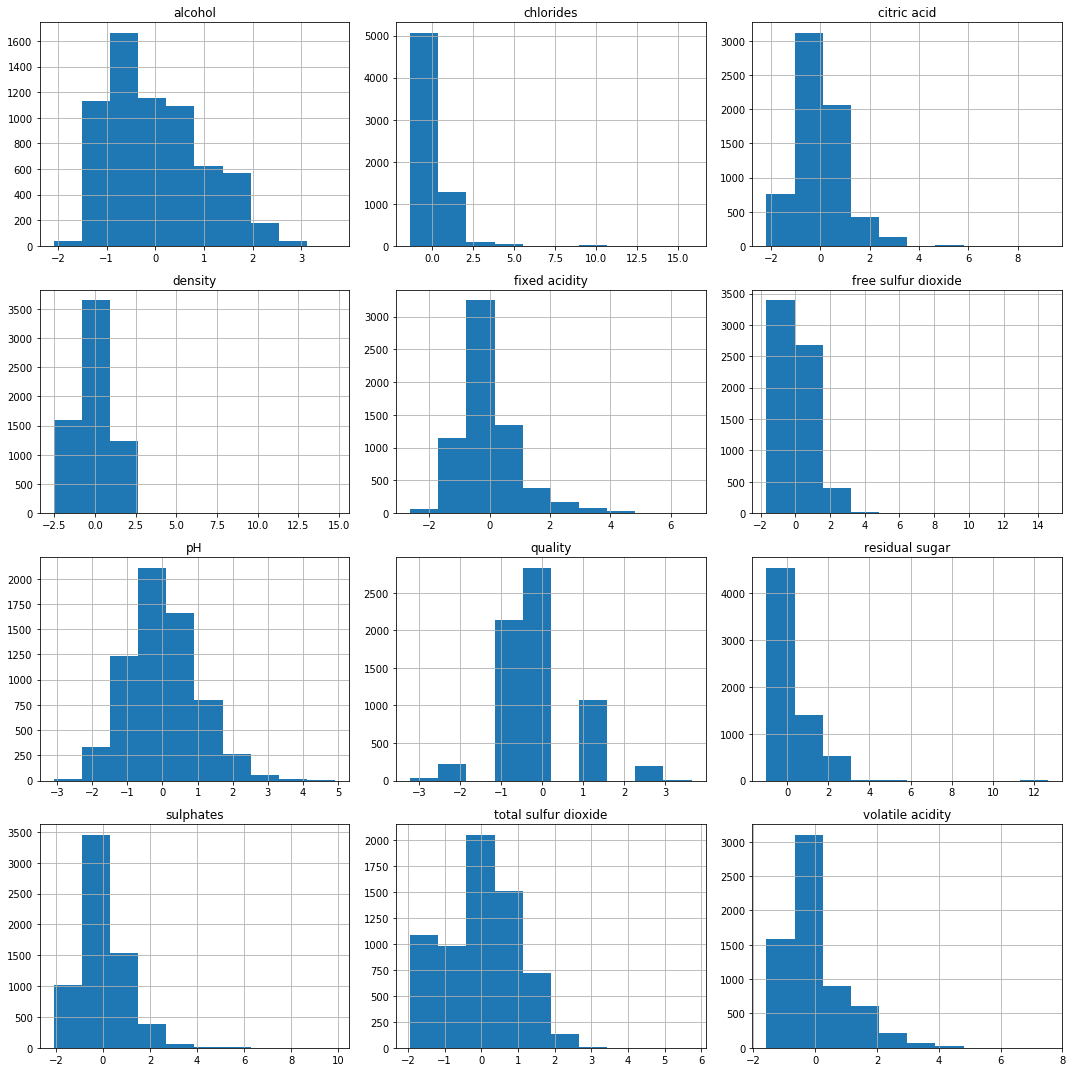

In [50]:
obj.normalize(method="zscore",reset=True)
obj.visuals()

In [75]:
obj = Normalizator(dataset="wine")
obj.normalize(method="zscore",reset=True)
obj.visuals()

TypeError: data type "category" not understood